In [1]:
import pickle
import argparse
import random
import numpy as np
import time
import os
import sys
import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from pytorch_model import *
import matplotlib.pyplot as plt
from utils import *
from vocab import Vocabulary

In [47]:
MODEL = "nn" # help="nn or rnn"
USE_EMBED = True # help='True to use GloVe embeddings'
COLLATE_FN ="sum" # help='avg or sum, used for nn model only'
REMOVE_NUMBERS = False # help='in preproc, replace numbers if true'
USE_SPELLCHECK = False # help='in preproc, spellcheck all words if true'
NORMALIZE_SCORES = True # help='True to predict normalized scores (min 0, max 1)'
GLOVE_DIM = 200 # help='dimension for GloVe embeddings'

In [16]:
train_data = pickle.load(open('data/train.pkl', 'rb'))
dev_data = pickle.load(open('data/dev.pkl', 'rb'))

In [145]:
train_answers, train_scores = prepare_data(train_data, use_normalized=True)
dev_answers, dev_scores = prepare_data(dev_data, use_normalized=True)

In [19]:
glove_home = os.path.join('vsmdata', 'glove.6B')
glove_lookup = glove2dict(os.path.join(glove_home, 'glove.6B.%dd.txt' % GLOVE_DIM))

array([[0.72222222],
       [1.        ],
       [1.        ],
       ...,
       [0.8       ],
       [0.9       ],
       [0.96      ]])

In [146]:
train_scores_binary = np.array([1.0 if (x == 1.0) else 0.0 for x in train_scores]).reshape(-1, 1)
dev_scores_binary = np.array([1.0 if (x == 1.0) else 0.0 for x in dev_scores]).reshape(-1, 1)

In [147]:
print("Perfect answers (train):", len(train_scores_binary[train_scores_binary == 1.0]))
print("Non-perfect answers (train):", len(train_scores_binary[train_scores_binary == 0.0]))
print("Perfect answers (test):", len(dev_scores_binary[dev_scores_binary == 1.0]))
print("Non-perfect answers (test):", len(dev_scores_binary[dev_scores_binary == 0.0]))

Perfect answers (train): 1446
Non-perfect answers (train): 4427
Perfect answers (test): 191
Non-perfect answers (test): 543


In [50]:
train_x = []
dev_x = []

print("Processing strings")
print("Using model: {}".format(MODEL))
print("Using embeddings: {}".format(USE_EMBED))
if MODEL == "nn":
    print("Using collate function: {}".format(COLLATE_FN))
for train_answer in train_answers:
    features = process(train_answer, REMOVE_NUMBERS, USE_SPELLCHECK)
    # RNN should have data as timeseries
    if MODEL == "rnn":
        # with embeddings, each timestep is a glove vector of shape=(args.glove_dim, 1)
        if USE_EMBED:
            features = embed(features, glove_lookup, dim=GLOVE_DIM)
        # without embeddings, each time step is a word index of shape=(1,)
        else:
            features = [vocab(x) for x in features.split(' ')]
    elif MODEL == "nn":
        features = embed(features, glove_lookup, dim=GLOVE_DIM, collate_fn=COLLATE_FN)
    else:
        raise NotImplementedError
    if not isinstance(features, float):
        train_x.append(features)

for dev_answer in dev_answers:
    features = process(dev_answer, REMOVE_NUMBERS, USE_SPELLCHECK)
    # RNN should have data as timeseries
    if MODEL == "rnn":
        # with embeddings, each timestep is a glove vector of shape=(args.glove_dim, 1)
        if USE_EMBED:
            features = embed(features, glove_lookup, dim=GLOVE_DIM)
        # without embeddings, each time step is a word index of shape=(1,)
        else:
            features = [vocab(x) for x in features.split(' ')]
    elif MODEL == "nn":
        features = embed(features, glove_lookup, dim=GLOVE_DIM, collate_fn=COLLATE_FN)
    else:
        raise NotImplementedError
    if not isinstance(features, float):
        dev_x.append(features)
print(" - done.")

Processing strings
Using model: nn
Using embeddings: True
Using collate function: sum
 - done.


In [55]:
train_x = np.array(train_x)
print(train_x.shape)

(5873, 200)


In [27]:
from sklearn.decomposition import PCA
embeds = pickle.load(open('data/learned_embeds.pkl', 'rb'))[2]
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(embeds)
print(principalComponents.shape)

(362, 30)


In [21]:
from sklearn.manifold import TSNE

In [28]:
X_embedded = TSNE(n_components=2).fit_transform(principalComponents)
X_embedded.shape

(362, 2)

In [29]:
#indices_nonzero = np.nonzero(train_scores)
train_scores = pickle.load(open('data/learned_embeds.pkl', 'rb'))[0]
zero_indices = np.argwhere(np.array(train_scores) <= 0.5)
one_indices = np.argwhere(np.array(train_scores) > 0.5)

In [30]:
X_embedded_zero = X_embedded[zero_indices].squeeze()
X_embedded_one = X_embedded[one_indices].squeeze()

In [31]:
print("Zero t-sne shape:", X_embedded_zero.shape)
print("One t-sne shape:", X_embedded_one.shape)

Zero t-sne shape: (65, 2)
One t-sne shape: (297, 2)


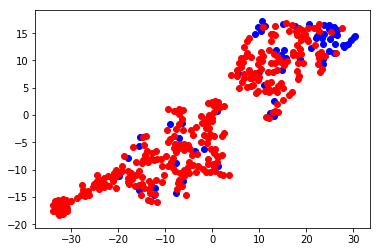

In [32]:
plt.scatter(X_embedded_zero[:,  0],  X_embedded_zero[:,  1],  color='b')
plt.scatter(X_embedded_one[:,  0],  X_embedded_one[:,  1],  color='r')

In [102]:
train_x.shape

(5873, 200)

In [133]:
train_x_set = [row for row in train_x]
print(len(train_x_set))

5873


In [135]:
for i, row in enumerate(train_x_set):
    for j, row2 in enumerate(train_x_set):
        if j > i:
            if np.allclose(row, row2):
                print(i, j)

2 63
2 73
2 85
2 102
2 201
2 284
2 451
2 469
2 477
2 503
2 659
2 733
2 776
2 894
2 950
2 982
2 1008
2 1032
2 1052
2 1109
2 1162
2 1165
2 1210
2 1317
2 1374
2 1399
2 1439
2 1449
2 1453
2 1488
2 1491
2 1500
2 1533
2 1534
2 1594
2 1597
2 1621
2 1623
2 1627
2 1681
2 1714
2 1803
2 1851
2 1855
2 1863
2 1992
2 2015
2 2095
2 2129
2 2202
2 2215
2 2237
2 2266
2 2284
2 2292
2 2315
2 2326
2 2364
2 2405
2 2408
2 2465
2 2487
2 2541
2 2612
2 2675
2 2690
2 2691
2 2732
2 2812
2 2816
2 2872
2 2914
2 2920
2 3013
2 3109
2 3146
2 3207
2 3229
2 3253
2 3291
2 3385
2 3453
2 3524
2 3527
2 3597
2 3611
2 3619
2 3646
2 3654
2 3698
2 3708
2 3850
2 3864
2 3896
2 3910
2 3916
2 3925
2 3998
2 4032
2 4048
2 4109
2 4138
2 4160
2 4255
2 4285
2 4318
2 4343
2 4346
2 4347
2 4348
2 4368
2 4388
2 4467
2 4479
2 4492
2 4542
2 4543
2 4544
2 4545
2 4577
2 4590
2 4608
2 4622
2 4660
2 4758
2 4884
2 4935
2 4953
2 4977
2 5065
2 5117
2 5305
2 5307
2 5376
2 5398
2 5445
2 5475
2 5505
2 5516
2 5554
2 5600
2 5656
2 5678
2 5736
2 5791
2 58

KeyboardInterrupt: 

In [150]:
raw_answer1 = train_answers[2]
p1 = process(raw_answer1, False, False)
e1 = embed(p1, glove_lookup, dim=GLOVE_DIM, collate_fn=COLLATE_FN)
print(raw_answer1)
print(p1)
print(train_scores[2])
print(train_scores_binary[2])

/** 1C **/
// print out all values in the given hashmap.
// you are guaranteed that each value in the map is unique
// thus you don't need to worry about duplicates.
private void printValues(HashMap<String, String> map) {
    for(String key: map.keySet()){
        println(map.get(key));
    }
}
print out all values in the given hashmap you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values hash map string string map for string key map key set println map get key
[1.]
[1.]


In [151]:
raw_answer2 = train_answers[63]
p2 = process(raw_answer2, False, False)
e2 = embed(p2, glove_lookup, dim=GLOVE_DIM, collate_fn=COLLATE_FN)
print(raw_answer2)
print(p2)
print(train_scores[63])
print(train_scores_binary[63])

/** 1C **/
// print out all values in the given hashmap.
// you are guaranteed that each value in the map is unique
// thus you don't need to worry about duplicates.
private void printValues(HashMap<String, String> map) {
	for(String key : map.keySet()) {
	    String value = map.get(key);
	    println(key + " , " value);
	}
}
print out all values in the given hashmap you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values hash map string string map for string key map key set string value map get key println key value
[0.75]
[0.]


In [152]:
raw_answer2 = train_answers[73]
p2 = process(raw_answer2, False, False)
e2 = embed(p2, glove_lookup, dim=GLOVE_DIM, collate_fn=COLLATE_FN)
print(raw_answer2)
print(p2)
print(train_scores[73])
print(train_scores_binary[73])

/** 1C **/
// print out all values in the given hashmap.
// you are guaranteed that each value in the map is unique
// thus you don't need to worry about duplicates.
private void printValues(HashMap<String, String> map) {
	for (String key : map.keySet()) {
	    String value = map.get(key);
	    println("Key: " + key + ", Value: " + value);
	}
	
	
}
print out all values in the given hashmap you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values hash map string string map for string key map key set string value map get key println key key value value
[0.75]
[0.]
